In [111]:
import tweepy
from tweepy import OAuthHandler
import csv
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import word_tokenize
import re
from datetime import datetime, timedelta
import numpy as np

In [2]:
consumer_key = 'btcJCKDrw3xxftWgZX0VbwzFE'
consumer_secret = 'fNbyLsESWNYDAjys43rdTAsq1OmZsmeE3oYhkrORKLkth3Yfe6'
access_token = '920256767724019712-RIE4TN6tN5eEOqQKCwngG3oByt5mJaH'
access_secret = 'ESHGh6HTmCRPPG7VR4IakO6uskPkEREloXjYm2K4cCbOD'
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

In [14]:
def get_tweets(usernames, number_of_tweets):
    for username in usernames:
        tweets = api.user_timeline(screen_name=username, count=number_of_tweets, tweet_mode='extended', include_rts = True)

        tweet_arr = []
        tweets_csv = [[tweet.id_str, tweet.created_at, tweet.full_text.encode("utf-8"), tweet.favorite_count, tweet.retweet_count] for tweet in tweets]
        for j in tweets_csv:
            tweet_arr.append(j)

        with open('%s_tweets.csv' % username, 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['id','created_at','text', 'fav_count', 'retweet_count'])
            writer.writerows(tweets_csv)
        pass

In [15]:
get_tweets(['RozeckaPL', 'GoTracz', 'martalempart', 'MichalakJerzy', 'KatarzynaObara', 'SutrykJacek'], 30)

In [56]:
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
#     r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

special_chars = {
    '\\xc4\\x99': 'ą',
    '\\xc4\\x85': 'ą',
    '\\xc4\\x87': 'ć',
#     '\\xe2\\x80\\xa6': 'ć',
    '\\xc5\\x82': 'ł',
    '\\xc5\\x84': 'ń',
    '\\xc3\\xb3': 'ó',
    '\\xc5\\x9b': 'ś',
    '\\xc5\\xba': 'ź',
    '\\xc5\\xbc': 'ż',
    '\\xe2\\x80\\x93': '–'
}

separators = [',', '.', "'", '\\', 'x']
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

def special_characters(dataframes):
    for dataframe in dataframes:
        i = 0
        for data in dataframe.text:
            for key in special_chars:
                data = data.replace(key, special_chars[key])
            dataframe.text[i] = data
            i+=1

def extract_text(data_tokens):
    data = preprocess(data_tokens)
    data = extract_hashtags(data)
    data = extract_mentions(data)
    data = extract_links(data)
    data = extract_separators(data)
    return ' '.join(data)

def extract_text_from_dataframe(dataframe):
    arr = []
    for data in dataframe:
        arr.append(extract_text(data))
    return arr

def extract_text_from_dataframes(dataframes):
    i = 0
    for dataframe in dataframes:
        dataframe.text = extract_text_from_dataframe(dataframe.text)
        i+=1

def extract_hashtags(data_tokens):
    return list(filter(lambda token : '#' not in token, data_tokens))

def extract_mentions(data_tokens):
    return list(filter(lambda token : '@' not in token, data_tokens))

def extract_links(data_tokens):
    return list(filter(lambda token : 'http' not in token, data_tokens))
        
def extract_separators(data_tokens):
    return list(filter(lambda token : not any(x in token for x in separators) and token != 'b' and token != 'n', data_tokens))

def change_to_datetime(dataframes):
    for dataframe in dataframes:
        i=0
        for time in dataframe.created_at:
            dataframe.created_at[i] = datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
            i+=1

In [16]:
data_rozecka = pd.read_csv('RozeckaPL_tweets.csv')
data_tracz = pd.read_csv('GoTracz_tweets.csv')
data_lempart = pd.read_csv('martalempart_tweets.csv')
data_michalak = pd.read_csv('MichalakJerzy_tweets.csv')
data_obara = pd.read_csv('KatarzynaObara_tweets.csv')
data_sutryk = pd.read_csv('SutrykJacek_tweets.csv')
datasets = [data_rozecka, data_tracz, data_lempart, data_michalak, data_obara, data_sutryk]
special_characters(datasets)
change_to_datetime(datasets)
print(data_rozecka.text[2])

C:\Users\Pawel\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


b'RT @wirtualnapolska: Już dziś w programie "Wyborczy Grill" gościć bądziemy @RozeckaPL. Macie pytania do kandydatki na prezydenta Wrocławia?\xe2\x80\xa6'


In [18]:
extract_text_from_dataframes(datasets)

In [83]:
print(data_rozecka.created_at[0])
aggregate_by_hour(datetime.strptime("2018-10-16", "%Y-%m-%d"), data_rozecka.created_at)

2018-10-16 09:05:26


[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [131]:
def visualize_retweets_daily(datasets, names, date):
    date = datetime.strptime(date, "%Y-%m-%d")
    hours = range(1, 25)
    i = 0
    fig, axs = plt.subplots(len(names), 1, figsize=(15,30))
    plt.tight_layout(h_pad=5.0)
    for data, name in zip(datasets, names):
        agg_hours = [0] * 24
        for text, curr_date in zip(data.text, data.created_at):
            agg_hours = aggregate_by_hour(date, data, True)
        plt.sca(axs[i])
        plt.xticks(hours)
        axs[i].set_title(name)
        axs[i].set_xlabel('Hours')
        axs[i].set_ylabel('Retweets')
        axs[i].plot(hours, agg_hours)
        i+=1

def visualize_tweets_daily(datasets, names, date):
    date = datetime.strptime(date, "%Y-%m-%d")
    hours = range(1, 25)
    i = 0
    fig, axs = plt.subplots(len(names), 1, figsize=(15,30))
    plt.tight_layout(h_pad=5.0)
    for data, name in zip(datasets, names):
        agg_hours = [0] * 24
        for text, curr_date in zip(data.text, data.created_at):
            agg_hours = aggregate_by_hour(date, data, False)
        plt.sca(axs[i])
        plt.xticks(hours)
        axs[i].set_title(name)
        axs[i].set_xlabel('Hours')
        axs[i].set_ylabel('Retweets')
        axs[i].plot(hours, agg_hours)
        i+=1

def aggregate_by_hour(date, data, rt=False):
    hours = [0] * 24
    for text,curr_date in zip(data.text, data.created_at):
        if rt:
            if text.startswith('RT') and date.year == curr_date.year and date.month == curr_date.month and date.day == curr_date.day:
                    hours[curr_date.hour] += 1
        elif not text.startswith('RT') and date.year == curr_date.year and date.month == curr_date.month and date.day == curr_date.day:
            hours[curr_date.hour] += 1
    return hours
    

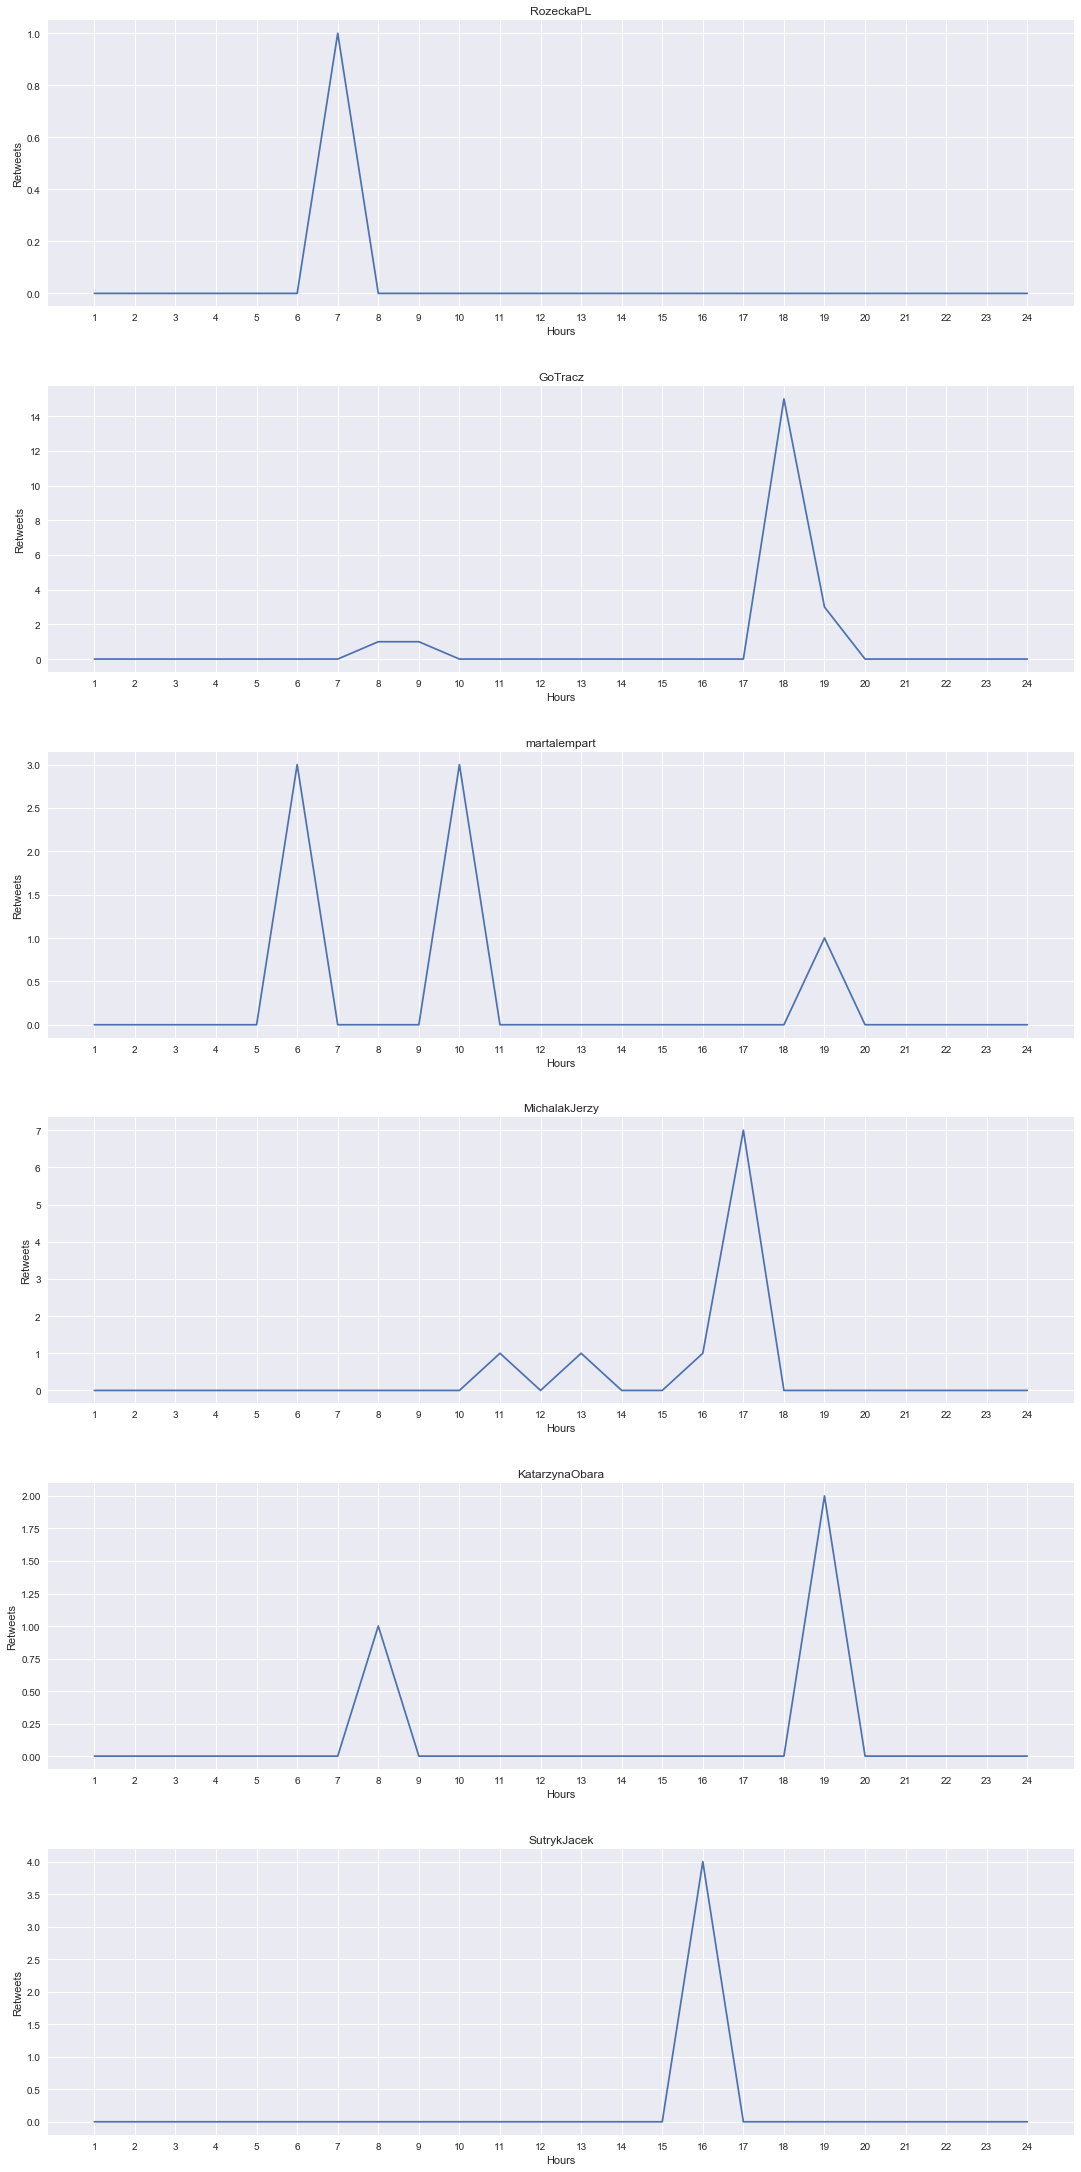

In [130]:
names = ['RozeckaPL', 'GoTracz', 'martalempart', 'MichalakJerzy', 'KatarzynaObara', 'SutrykJacek']
day = datetime.strptime("2018-10-16", "%Y-%m-%d")
visualize_retweets_daily(datasets, names, '2018-10-16')
# for data, text in zip(datasets[0].created_at, datasets[0].text):
#     print(data, text[:2])

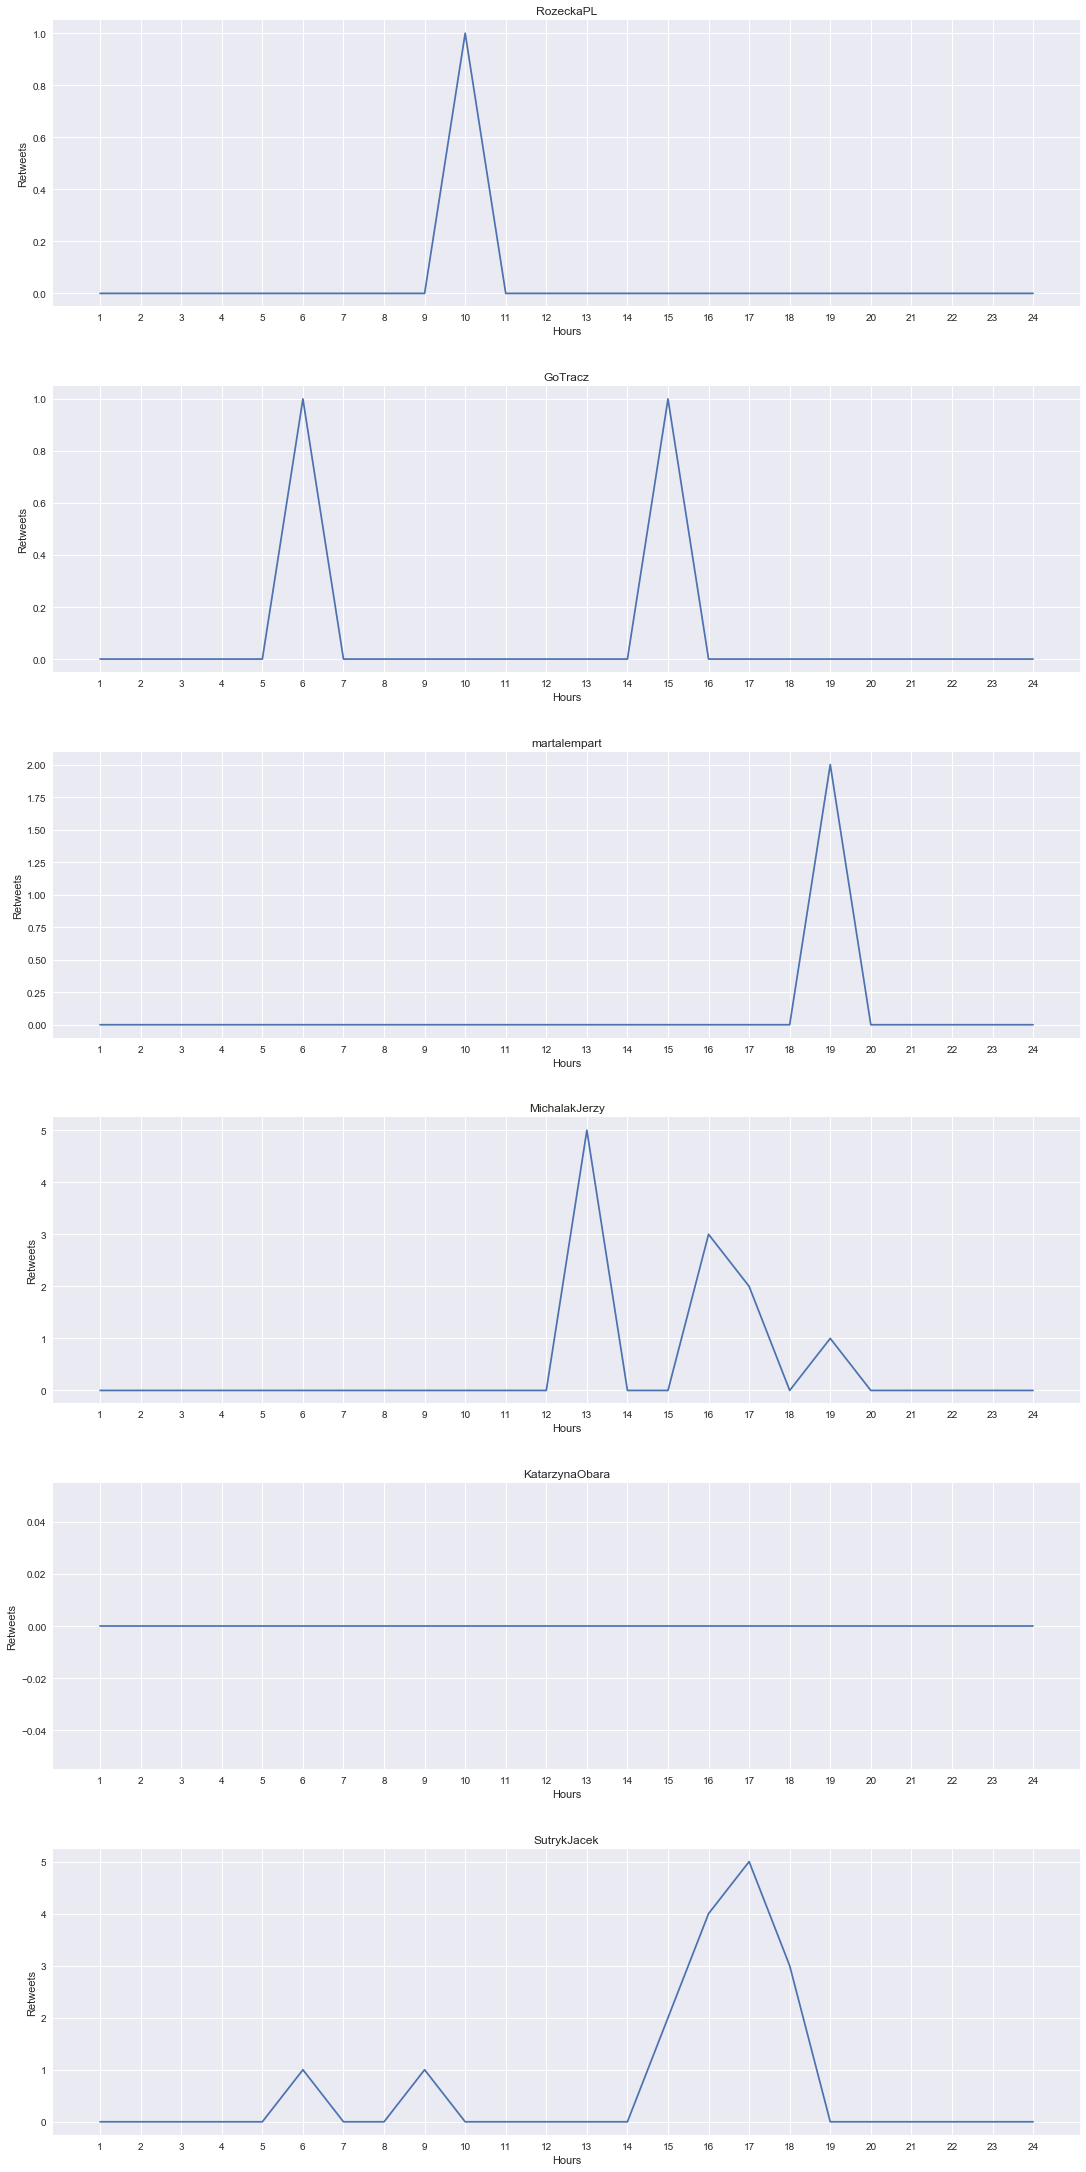

In [132]:
visualize_tweets_daily(datasets, names, '2018-10-16')

In [9]:
def visualize_tweets_retweets(datasets, names):
    i = 0
    fig, axs = plt.subplots(len(names), 1, figsize=(15,30))
    plt.tight_layout(h_pad=15.0)
    for data, name in zip(datasets, names):
        plt.sca(axs[i])
        plt.xticks(rotation=90)
        axs[i].set_title(name)
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Retweets')
        axs[i].plot(data.created_at, data.retweet_count)
        i+=1
        
def visualize_tweets_favs(datasets, names):
    i = 0
    fig, axs = plt.subplots(len(names), 1, figsize=(15,30))
    plt.tight_layout(h_pad=15.0)
    for data, name in zip(datasets, names):
        plt.sca(axs[i])
        plt.xticks(rotation=90)
        axs[i].set_title(name)
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Favorites')
        axs[i].plot(data.created_at, data.fav_count)
        i+=1

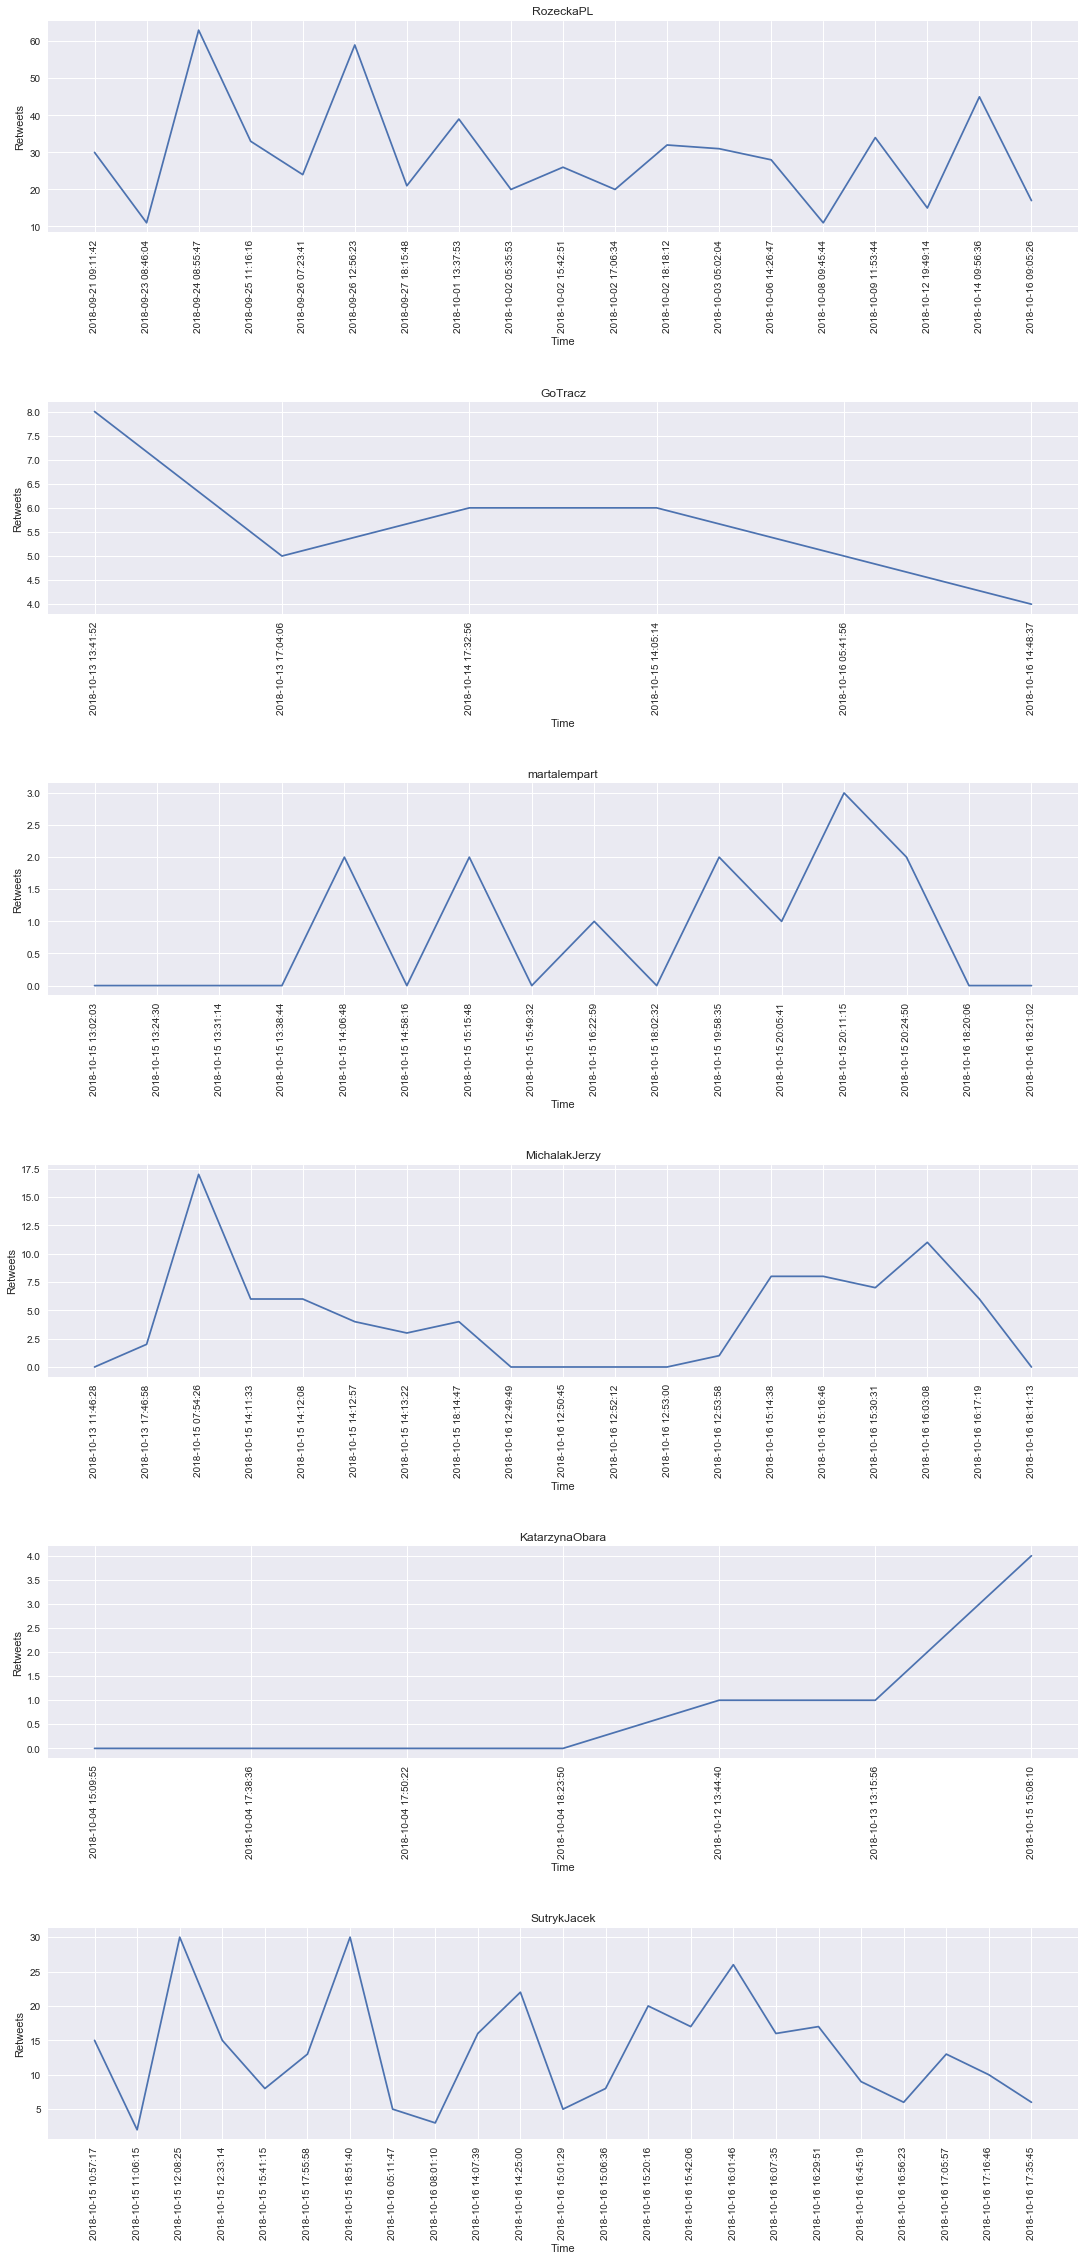

In [10]:
visualize_tweets_retweets(datasets, ['RozeckaPL', 'GoTracz', 'martalempart', 'MichalakJerzy', 'KatarzynaObara', 'SutrykJacek'])

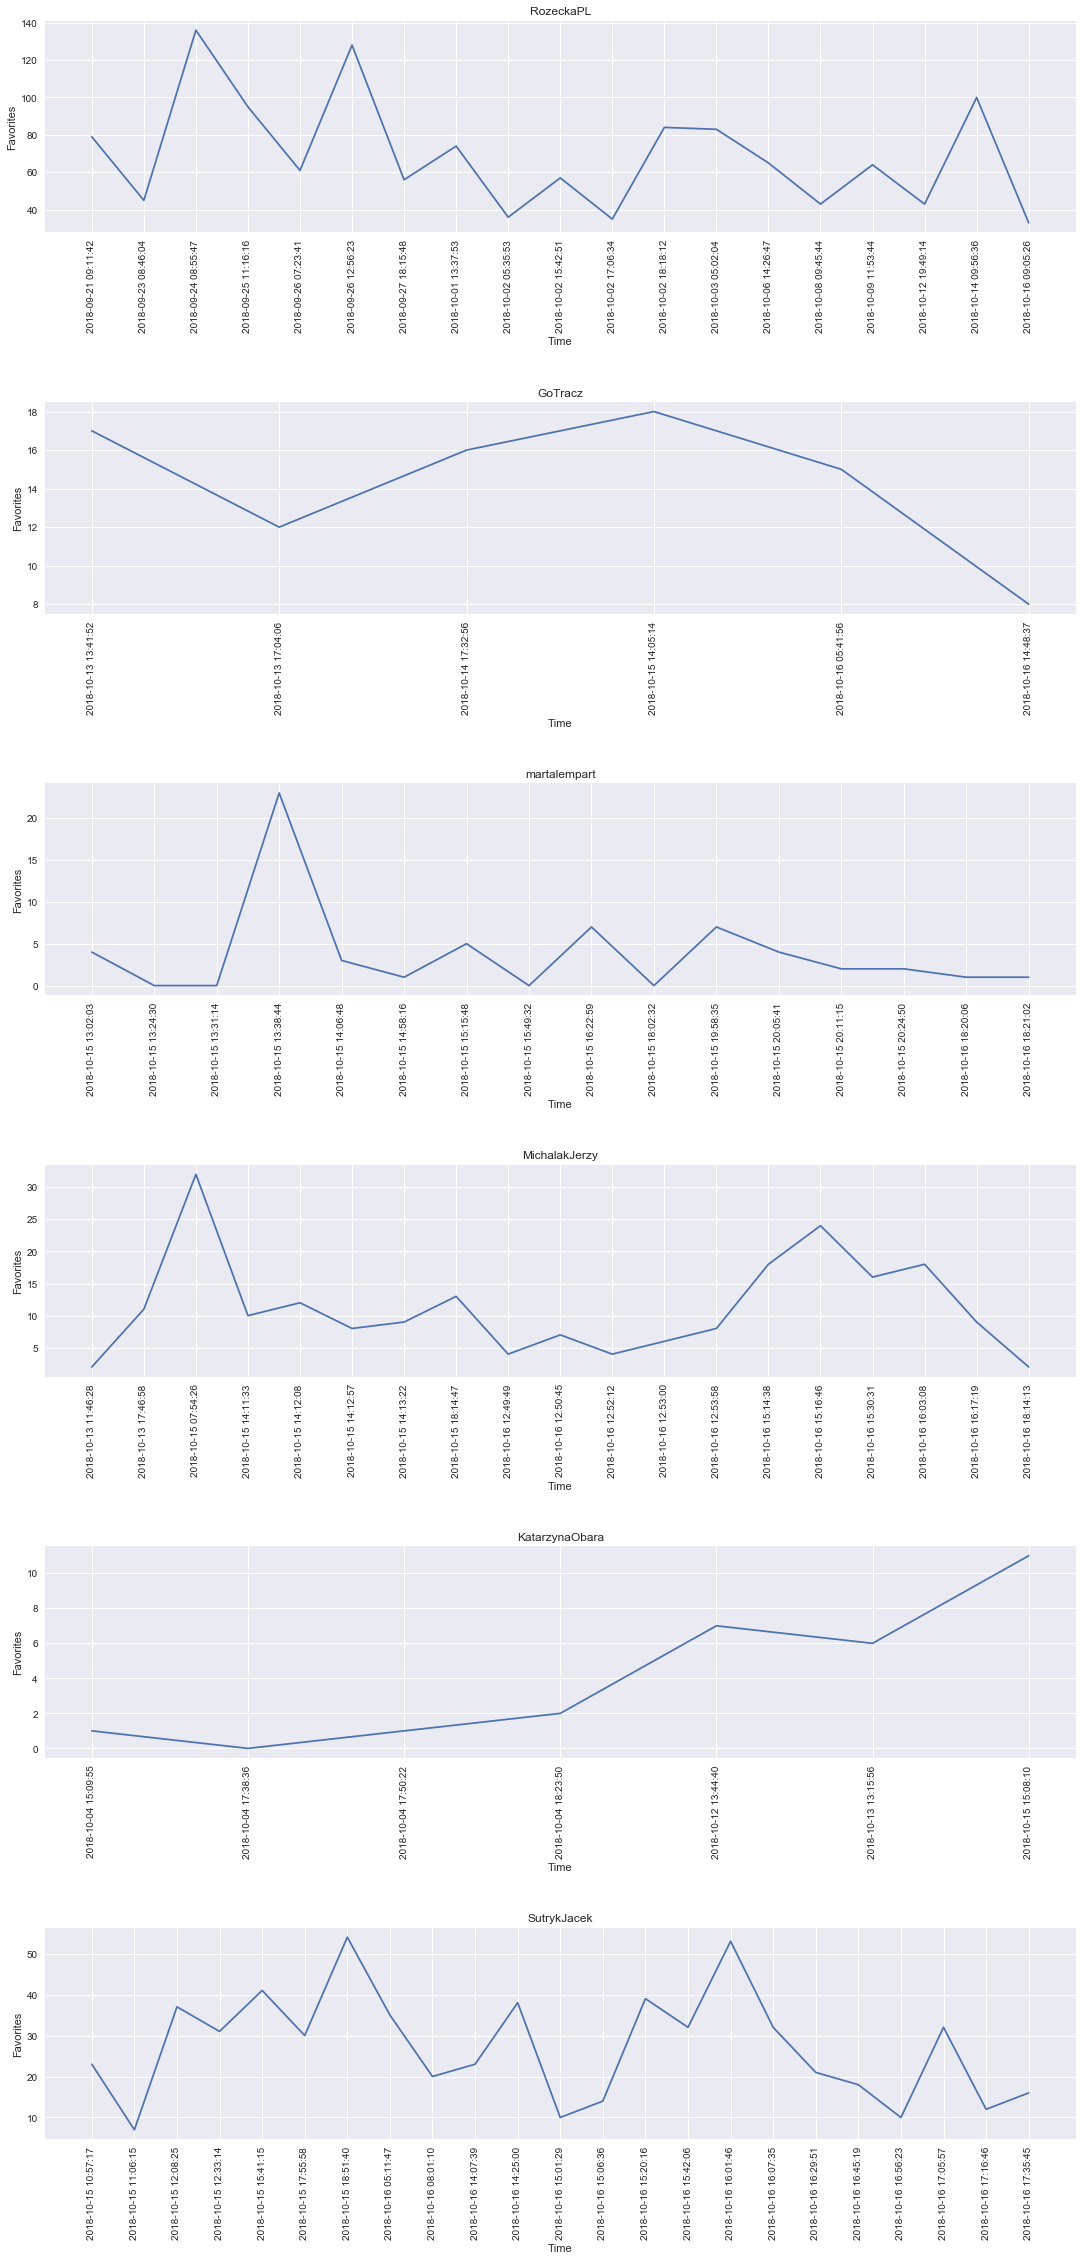

In [11]:
visualize_tweets_favs(datasets, ['RozeckaPL', 'GoTracz', 'martalempart', 'MichalakJerzy', 'KatarzynaObara', 'SutrykJacek'])